## Detectando Melanoma utilizando Redes Neurais Profundas

### Origem dos dados: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images


### Imports

In [1]:
import tensorflow
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import log, mean
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import math
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

In [2]:
!unzip Melanoma.zip

'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


### Fazendo um dataset simples contendo o nome dos arquivos ( e se é melanoma ou não).

In [3]:

%cd melanoma_cancer_dataset

base_dirs = ['train', 'test']
labels = {'malignant': 1, 'benign': 0}

data = []

for base_dir in base_dirs:
    for label_name, label_value in labels.items():
        sub_dir = os.path.join(base_dir, label_name)
        for root, _, files in os.walk(sub_dir):
            for file in files:
                file_path = os.path.join(root, file)
                data.append([file_path, label_value])

df = pd.DataFrame(data, columns=['archive_name', 'is_melanoma'])

train_dataset = df[df['archive_name'].str.contains('train')]
test_data = df[df['archive_name'].str.contains('test')]

test_dataset, validation_dataset = train_test_split(test_data, test_size=0.2, random_state=42)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")


d:\Redes_Neurais (Medical Problems)\Melanoma_Deteccao\melanoma_cancer_dataset
Train dataset size: 9605
Test dataset size: 800
Validation dataset size: 200


C:\Users\tarik\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:

def balancear_dataset(dataset):
    """
    Recebe um dataset e retorna um dataset balanceado com 50% de casos malignos e 50% de casos benignos.

    Parâmetros:
        dataset (pd.DataFrame): O DataFrame contendo os dados para balancear, com uma coluna 'is_melanoma'.

    Retorna:
        pd.DataFrame: Dataset balanceado.
    """

    malignos = dataset[dataset['is_melanoma'] == 1]
    benignos = dataset[dataset['is_melanoma'] == 0]

    num_benignos = len(benignos)
    num_malignos = len(malignos)

    if num_benignos == num_malignos:
        return dataset

    if num_malignos < num_benignos:
        malignos_replicados = malignos.sample(num_benignos, replace=True)
        balanced_dataset = pd.concat([malignos_replicados, benignos])
    else:
        benignos_replicados = benignos.sample(num_malignos, replace=True)
        balanced_dataset = pd.concat([malignos, benignos_replicados])

    return balanced_dataset.sample(frac=1).reset_index(drop=True)


### É visto que há um desbalanceamento no dataset de treino, possuindo mais casos benignos do que malignos. Por isso, será necessário replicar algumas instâncias para que assim esteja mais balanceado.

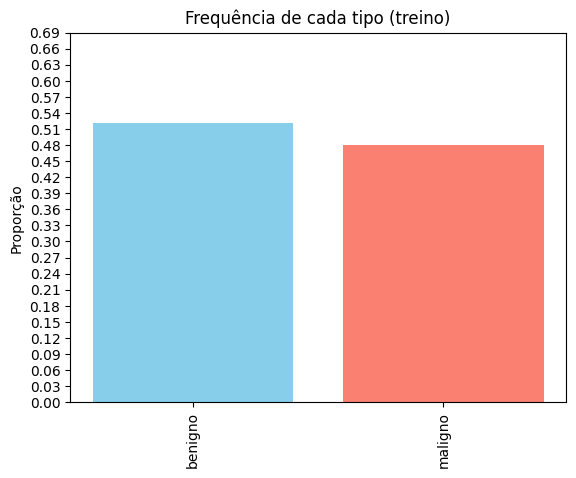

In [5]:
mean_maligno = np.mean(train_dataset['is_melanoma'])

mean_benigno = 1 - mean_maligno

plt.bar(x=["benigno", "maligno"], height=[mean_benigno, mean_maligno], color=['skyblue', 'salmon'])

plt.yticks(np.arange(0, 0.7, 0.03))

plt.xticks(rotation=90)
plt.title("Frequência de cada tipo (treino)")
plt.ylabel("Proporção")
plt.show()


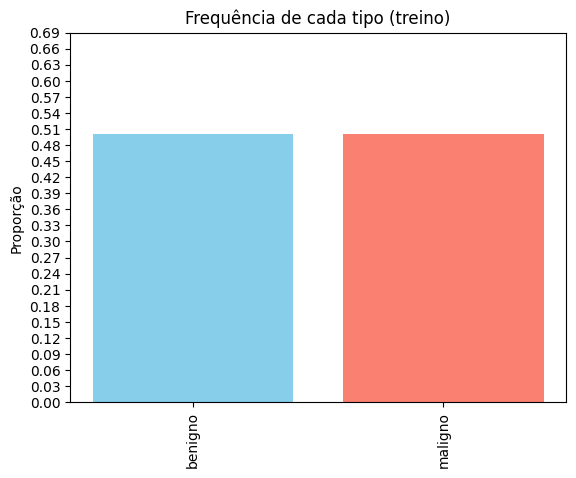

In [6]:
train_dataset = balancear_dataset(train_dataset)

mean_maligno = np.mean(train_dataset['is_melanoma'])

mean_benigno = 1 - mean_maligno

plt.bar(x=["benigno", "maligno"], height=[mean_benigno, mean_maligno], color=['skyblue', 'salmon'])

plt.yticks(np.arange(0, 0.7, 0.03))

plt.xticks(rotation=90)
plt.title("Frequência de cada tipo (treino)")
plt.ylabel("Proporção")
plt.show()

### Agora podemos usar o gerador de imagens para modificar as imagens e facilitar o treino do modelo. Os pixeis serão normalizados, e as imagens redimensionadas para 300x300 (mesmo que, de acordo com o dataset, as imagens já possuem essa dimensão). Será feita a técnica de Image Augmentation, onde a imagem é levemente rotacionada e modificada para o modelo perceber com mais facilidade certos padrões. Além disso, serão utilizados batches de 32 imagens para facilitar o treino.

In [32]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_generator = image_generator.flow_from_dataframe(
            dataframe=train_dataset,
            directory=".",
            x_col="archive_name",
            y_col="is_melanoma",
            class_mode="raw",
            batch_size=64,
            shuffle=True,
            seed=42,
            target_size=(300,300))

test_generator = image_generator.flow_from_dataframe(
            dataframe=test_dataset,
            directory=".",
            x_col="archive_name",
            y_col="is_melanoma",
            class_mode="raw",
            batch_size=64,
            shuffle=True,
            seed=42,
            target_size=(300,300))



validation_generator = image_generator.flow_from_dataframe(
            dataframe=validation_dataset,
            directory=".",
            x_col="archive_name",
            y_col="is_melanoma",
            class_mode="raw",
            batch_size=64,
            shuffle=True,
            seed=42,
            target_size=(300,300))

Found 10000 validated image filenames.
Found 800 validated image filenames.
Found 200 validated image filenames.


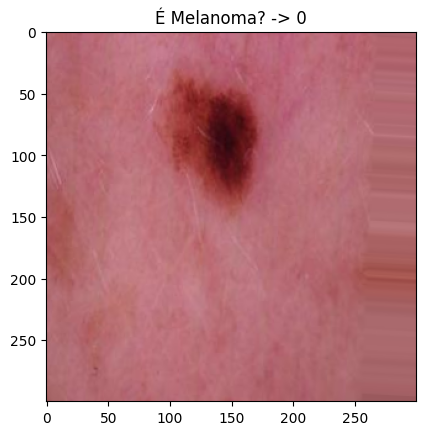

In [8]:

x, y = next(train_generator)

random_index = np.random.randint(0, len(x))
image = x[random_index]

plt.imshow(image)
plt.title(f"É Melanoma? -> {y[random_index]}")
plt.show()


### Com tudo pronto, usaremos parte do modelo DenseNet121, treinado com pesos da imagenet, fazendo o modelo mais apto para interpretar certos padrões nas imagens.
### Adição de camada GlobalAveragePooling2D para transformar a matriz de imagem e permitir melhor aprendizado do modelo, além de Camada Dense e Dropout para evitar overfitting.
### Por fim, utilizado um otimizar Adam com uma perda Binary Crossentropy, padrão em muitas CNNs.

In [48]:
lambda_value = 0.01

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(lambda_value))(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(lambda_value))(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(lambda_value))(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(lambda_value))(x)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(lambda_value))(x)
x = Dropout(0.2)(x)

x = Dense(16, activation='relu', kernel_regularizer=l2(lambda_value))(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(lambda_value))(x)

model = Model(inputs=base_model.input, outputs=predictions)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#model.summary()


In [25]:
print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

TensorFlow version: 2.17.0
Eager execution: True


### Agora treinamos o modelo, treinando com 313 baches por época, e 25 batches por época em validação. Devido a complexidade do modelo, somente será treinado por 10 épocas.

In [50]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    batch_size=64,
                    epochs=10,
                    callbacks=[lr_scheduler])


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1899s 11s/step - accuracy: 0.6902 - loss: 6.8369 - val_accuracy: 0.8300 - val_loss: 1.0333 - learning_rate: 0.0010
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1738s 11s/step - accuracy: 0.8594 - loss: 0.8903 - val_accuracy: 0.8700 - val_loss: 0.5980 - learning_rate: 0.0010
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1560s 10s/step - accuracy: 0.8556 - loss: 0.6097 - val_accuracy: 0.8550 - val_loss: 0.5113 - learning_rate: 0.0010
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1582s 10s/step - accuracy: 0.8707 - loss: 0.5167 - val_accuracy: 0.8750 - val_loss: 0.4620 - learning_rate: 0.0010
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1662s 10s/step - accuracy: 0.8655 - loss: 0.5124 - val_accuracy: 0.8750 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1933s 12s/step - accuracy: 0.8696 - loss: 0.4890 - val_accuracy: 0.8300 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1796s 11s/step - accuracy: 0.8

### Salvando o modelo

In [51]:
model.save("modelo_treinado_melanoma.h5")

In [54]:
len(test_generator)

13

### Dados de teste e resultados finais da matriz de confusão utilizando 0.5 como threshould

In [65]:
steps = int(0.1 * len(validation_dataset))
valores_predicao = model.predict(validation_generator, steps=steps)


20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step  


c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


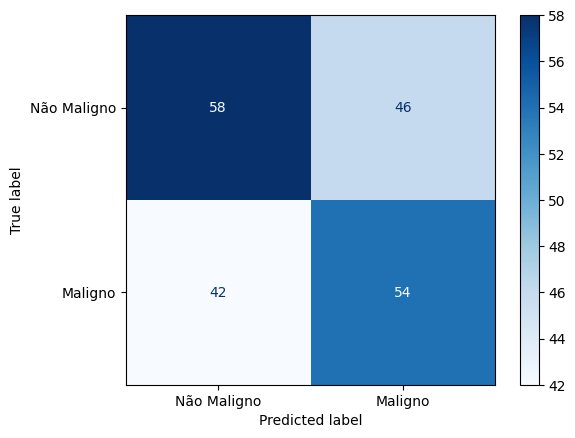

In [66]:
true_labels = validation_generator.labels
classes_preditas = (valores_predicao > 0.5).astype(int)
cm = confusion_matrix(true_labels, classes_preditas)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Maligno', 'Maligno'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [67]:
tn, fp, fn, tp = cm.ravel()

ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print(f"PPV (Valor Preditivo Positivo): {ppv}")
print(f"NPV (Valor Preditivo Negativo): {npv}")



PPV (Valor Preditivo Positivo): 0.54
NPV (Valor Preditivo Negativo): 0.58


### Curva ROC

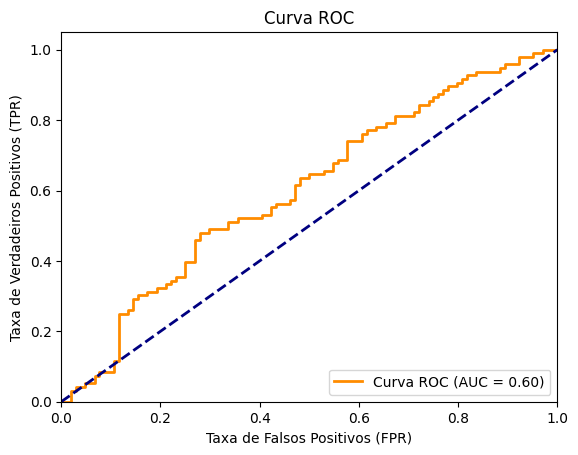

In [68]:
fpr, tpr, thresholds = roc_curve(true_labels, valores_predicao)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### Mesmo não possuindo um valor AUC ideal, podemos tentar encontrar o melhor threshold para ser usado pelo modelo para aumentar a sua acurácia.

In [69]:
def distancia_euclidiana(ponto1, ponto2):

  x1, y1 = ponto1
  x2, y2 = ponto2
  return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

melhor_distancia = float('inf')
melhor_limite = None
for i in range(len(fpr)):
  distancia = distancia_euclidiana((fpr[i], tpr[i]), (0, 1))
  if distancia < melhor_distancia:
    melhor_distancia = distancia
    melhor_limite = thresholds[i]

print(f"Melhor limite (threshold): {melhor_limite}")


Melhor limite (threshold): 0.9041523337364197


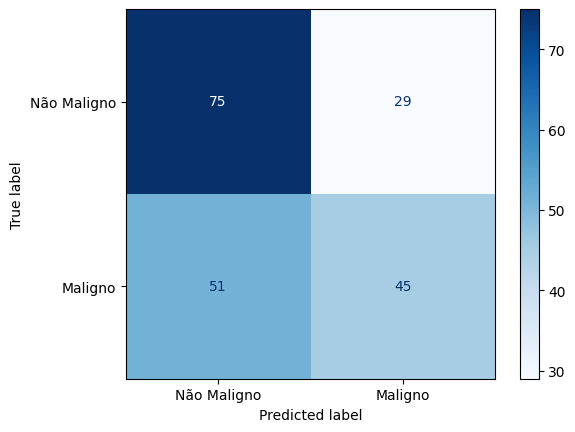

In [70]:
classes_preditas = (valores_predicao > melhor_limite).astype(int)
cm = confusion_matrix(true_labels, classes_preditas)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Maligno', 'Maligno'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [71]:
tn, fp, fn, tp = cm.ravel()

ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print(f"PPV (Valor Preditivo Positivo): {ppv}")
print(f"NPV (Valor Preditivo Negativo): {npv}")



PPV (Valor Preditivo Positivo): 0.6081081081081081
NPV (Valor Preditivo Negativo): 0.5952380952380952


### A AUCROC (área abaixo da curva ROC) de um modelo de previsão de melanoma indica a probabilidade de que, ao comparar um paciente que desenvolveu melanoma com outro que não, o modelo atribuirá corretamente um risco maior ao paciente que apresentou a doença, auxiliando na detecção precoce e no manejo clínico.

In [72]:
roc_auc = auc(fpr, tpr)

print(f"AUCROC (Área Abaixo da Curva ROC): {roc_auc}")

AUCROC (Área Abaixo da Curva ROC): 0.6021634615384615


### A AUCROC de 0.602 indica que o modelo possui uma capacidade ligeiramente melhor que o acaso para distinguir entre pacientes que desenvolveram melanoma e aqueles que não

### Conclusões

#### Modelo ineficiente (ligeiramente melhor do que um modelo aleatório 50/50). Aumento do batch, adição de camadas de Dropout, e regulação L2 podem se mostrar eficientes. Além disso, treinar com mais épocas também pode se mostrar promissor.

#### O uso de normalização de imagens e de Image Augmentation devem ser revistas tendo em vista que pode dificultar a detecção das lesões pelo modelo (mesmo que essas técnicas geralmente são utilizadas em CNNs).